# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле toxic_comments.csv


- `text` — текст комментария,
- `toxic` — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Кросс-валидация" data-toc-modified-id="Кросс-валидация-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Кросс-валидация</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Случайный-лес-с-градиентным-бустингом" data-toc-modified-id="Случайный-лес-с-градиентным-бустингом-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Случайный лес с градиентным бустингом</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Подготовка

In [1]:
# Библиотеки
import time
from tqdm.notebook import tqdm_notebook as tqdm

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, auc, roc_curve
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))
pd.set_option('display.max_colwidth', 280)

RANDOM_STATE = 123

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weeqe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\weeqe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\weeqe\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\weeqe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\weeqe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
class hm:
    
    # Функция визуализирует каличества встречающихчя значений в pd.Series
    def plot_value_counts(series, n_values=25, fillna='NONE', figwidth=10):
        
        val_counts = series.fillna(fillna).value_counts()
        bar_values = val_counts.values[:n_values]
        bar_labels = val_counts.index[:n_values].astype('str')
        plt.figure(figsize=(figwidth, 0.5*min(len(val_counts), n_values)))
        ax = sns.barplot(x=bar_values, y=bar_labels)
        ax.set(title='"{}" value counts ({} / {})'
            .format(series.name, len(bar_labels), val_counts.shape[0]),
            xlim=[0, 1.075*bar_values.max()]
            )
        plt.bar_label(ax.containers[0])
        for i in range(len(bar_labels)):
            if bar_labels[i] == fillna:
                ax.patches[i].set_color('black')
        plt.show()
    
    # Функция выводит таблицу с показателями моделей, показавших наилучшие значения метрики на кроссвалидации.
    def best_cv_models(grid, count):
        
        print('Estimator: {}'.format(grid.estimator))
        print('Tested {} models. Splits: {}'.format(
            len(grid.cv_results_['params']), grid.cv))
        print('Best score = {}\n'.format(grid.best_score_))
        best_idx = grid.cv_results_['rank_test_score'].argsort()[:count]

        results = {}
        results['test score'] = grid.cv_results_['mean_test_score'][best_idx]
        if 'mean_train_score' in grid.cv_results_.keys():
            results['train score'] = grid.cv_results_['mean_train_score'][best_idx]
        results['fit time, s'] = grid.cv_results_['mean_fit_time'][best_idx]
        results['score time, s'] = grid.cv_results_['mean_score_time'][best_idx]

        return pd.DataFrame(results).join(
               pd.DataFrame([grid.cv_results_['params'][i] for i in best_idx]))
    
    # Функция строит ROC кривую для моделей из переданнойго словаря
    def roc_curve_plot(models, X_test, y_test, title='ROC Curve', labels=None, figsize=(10,8)):
        
        plt.figure(figsize=figsize)
        for name, model in models.items():
            pred = model.predict_proba(X_test)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_test, pred)
            roc_auc = auc(fpr, tpr)
            plt.title(title)
            plt.plot(fpr, tpr, label='AUC = %0.4f (%s)' % (roc_auc, name))
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.grid()
        plt.xlim([0, 1]), plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    
    # Функция возвращает score, время обучения, время пердсказаний и сами предсказания в виде словаря
    def test_model(model, X_train, X_test, y_train, y_test, score_func=None):

        # обучение
        t_beg = time.time()
        model.fit(X_train, y_train)
        time_fit = time.time() - t_beg
        # предсказания
        t_beg = time.time()
        y_pred = model.predict(X_test)
        time_predict = time.time() - t_beg
        # метрика
        score = score_func(y_test, y_pred)

        return {'score test': score,
                'fit time': time_fit,
                'predict time': time_predict
                }

In [3]:
# загрузим данные
try:
    df = pd.read_csv('C:/Users/weeqe/projects/data/toxic_comments.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [4]:
df.info()
print('Duplicates count:', df['text'].duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
Duplicates count: 0


In [5]:
df.head()

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do ...",0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [6]:
df.tail()

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most signif...",0
159288,159447,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159290,159449,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0
159291,159450,"""\nAnd ... I really don't think you understand. I came here and my idea was bad right away. What kind of community goes """"you have bad ideas"""" go away, instead of helping rewrite them. """,0


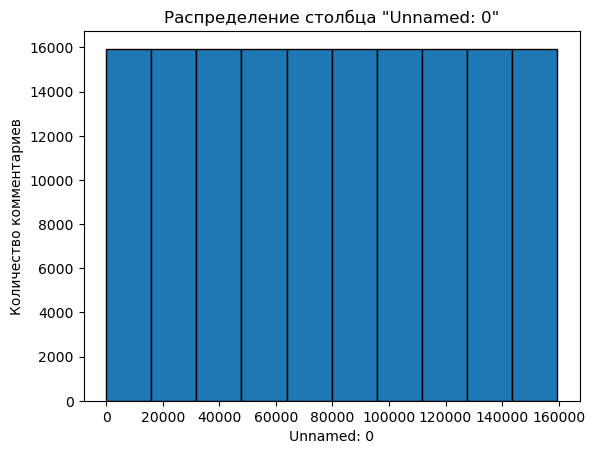

In [7]:
#оценим распределение
plt.hist(df['Unnamed: 0'],edgecolor='black')
plt.title('Распределение столбца "Unnamed: 0"')
plt.xlabel('Unnamed: 0')
plt.ylabel('Количество комментариев')
plt.show()

plt.hist(df['registration_year'],edgecolor='black')
plt.title('Регистрация автомобиля')
plt.xlabel('Годы')
plt.ylabel('Количество авто')
plt.show()

In [8]:
# никакой информации этот стобец не несет, поэтому удалим его.
df = df.drop('Unnamed: 0', axis=1)

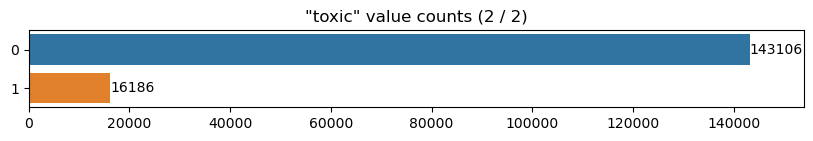

In [9]:
hm.plot_value_counts(df['toxic'])

Классы несбалансированы, поэтому для некоторых моделей необходимо будет их сбалансировать

In [10]:
df.sample(8)

,text,toxic
102613,Agreed\nI will do as you say.,0
24322,"""\n\nThis article is ludicrous, it paints anti-religonists with some kind of generalizing brush that Atheists have been getting away with for decades now. That is, that *we* can refer to ourselves in the 3rd person and apply any positive adjective we wish. I.e. O'Hare and oth...",1
145885,Everything is verified. Your attempting spin. And moderators like you have an agenda. I will report you.,0
8311,"Reverting - Cold War People \n\nPearle, I hope you don't mind my reverting your last edit. You've removed a lot of names form the category of cold war people, and rightly so, but Chamoun was a key figure, if not the key figure, in the Lebanon Crisis of 1958, which Eisenhower...",0
43033,and page is getting 76K hits an hour as a result.©,0
46002,"No, I'm not. It's sad you can't see that. I will repeat, as you don't seem to get it. The only reason Wereith was found, was because of my socking. As such, my infraction is minor, compared to his massive violation - despite the multiple bans, both arbcom and community, and a...",0
78129,"I don't think any of the above suggests any relationship, of any kind, between The Blob and the biotech concept of green (or even gray) goo. Here is the section which I have removed:\n\n *Unintended as it was at the time, The Blob is a perfect example of green goo (and of al...",0
51837,"To determine the reliablity of the site, we need to know what sort of fact checking they do. You can establish this by showing news articles that say the site is reliable/noteworthy/etc. or you can show a page on the site that gives their rules for submissions/etc. or you can...",0


Реализуем функцию для предобработки текстовых комментариев:
1. Приведём все комментарии к нижнему регистру
2. Удалим знаки пунктуации, оставив только латинские буквы
3. Разобъём каждый комментарий на отдельные слова
    - Удалим стоп-слова
    - Произведём лемматизацию слов
4. Соберём слова обратно в предложение, разделив пробелами

In [11]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)



def text_preprocesing(text, stop_words=None, lemmatize=True):
    words = re.sub(r'[^a-z]', ' ', text.lower()).split()
    if stop_words:
        words = [w for w in words if not w in stop_words]
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        lemma = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]

                
    return ' '.join(lemma)

Произведём предобработку и разделим данные на обучающую и тестовую выборки

In [12]:
df_=df[:5]
df_['text'] = df_['text'].apply(text_preprocesing, stop_words=stop_words)
df_.head()

C:\Users\weeqe\AppData\Local\Temp\ipykernel_56660\2055717991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['text'] = df_['text'].apply(text_preprocesing, stop_words=stop_words)


,text,toxic
0,explanation edits make username hardcore metallica fan revert vandalism closure gas vote new york doll fac please remove template talk page since retire,0
1,aww match background colour seemingly stuck thanks talk january utc,0
2,hey man really try edit war guy constantly remove relevant information talk edits instead talk page seem care format actual info,0
3,make real suggestion improvement wonder section statistic later subsection type accident think reference may need tidy exact format ie date format etc later one else first preference format style reference want please let know appear backlog article review guess may delay rev...,0
4,sir hero chance remember page,0


In [13]:
%%time
corpus = df['text'].apply(text_preprocesing, stop_words=stop_words)

X_train, X_test, y_train, y_test = (
    train_test_split(corpus, df['toxic'], test_size=0.25, random_state=RANDOM_STATE))

del corpus

Wall time: 39min 40s


Посмотрим на размер признакового пространсва после векторизации:

In [14]:
for r in [(1, 1), (2, 2), (1, 2)]:
    print('n-gram range {} : features count = {}'
          .format(r, TfidfVectorizer(ngram_range=r).fit_transform(X_train).shape[1]))

n-gram range (1, 1) : features count = 127936
n-gram range (2, 2) : features count = 1862803
n-gram range (1, 2) : features count = 1990739


При обучении на валидационной выборке ограничимся векторизацией отдельных слов, чтобы ускорить процесс обучения моделей и снизить объём используемой памяти.

Также, ограничим порог значимости признака `min_df = 1e-5`

## Кросс-валидация

Зададим общие параметры для кроссвалидации моделей
- метрика = `f1`
- количество разбиений = 3

Чтобы обеспечить "честное" тестирование и запускать векторизацию только на обучающей выборке, построим для каждой модели пайплайн. Иначе в модели будут учтены частоты слов из тестовой выборки.

In [15]:
cv_params = {'scoring': 'f1',
             'return_train_score': True,
             'cv': 3}

### Логистическая регрессия

In [16]:
%%time
pipe = Pipeline([('vct', TfidfVectorizer(min_df=1e-5)),
                 ('clf', LogisticRegression(class_weight='balanced', 
                                            random_state=RANDOM_STATE, 
                                            max_iter=500))
                ])
params = {'clf__solver': ['lbfgs', 'liblinear'],
          'clf__C': [0.1, 1, 10]
         } 
grid_lr = GridSearchCV(pipe, params, **cv_params, n_jobs=-1)
grid_lr.fit(X_train, y_train)
hm.best_cv_models(grid_lr, 10)

Estimator: Pipeline(steps=[('vct', TfidfVectorizer(min_df=1e-05)),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    random_state=123))])
Tested 6 models. Splits: 3
Best score = 0.7587403808691113

Wall time: 40.7 s


,test score,train score,"fit time, s","score time, s",clf__C,clf__solver
0,0.758740,0.923292,13.613641,1.964713,10.0,lbfgs
1,0.758740,0.923277,7.646681,1.989316,10.0,liblinear
2,0.743131,0.839849,8.431000,2.613220,1.0,lbfgs
3,0.743131,0.839789,6.259358,2.707558,1.0,liblinear
4,0.703730,0.743342,4.893502,2.856836,0.1,liblinear
5,0.703645,0.743344,5.410216,2.851715,0.1,lbfgs


- решатель `liblinear` предпочтительнее, поскольку работает быстрее, выдавая практически такой же скор
- C большими значениями параметра регуляризации `C` модель склонна к переобучению

In [17]:
%%time
pipe = Pipeline([('vct', TfidfVectorizer(min_df=1e-5)),
                 ('clf', LogisticRegression(class_weight='balanced',
                                            random_state=RANDOM_STATE,
                                            solver='liblinear',
                                            max_iter=500))
                ])
params = {'vct__ngram_range': [(1, 1), (1, 2)], 
          'clf__C': [1, 10]
          }
grid_lr = GridSearchCV(pipe, params, **cv_params, n_jobs=-1)
grid_lr.fit(X_train, y_train)
hm.best_cv_models(grid_lr, 10)

Estimator: Pipeline(steps=[('vct', TfidfVectorizer(min_df=1e-05)),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    random_state=123, solver='liblinear'))])
Tested 4 models. Splits: 3
Best score = 0.7789345042332355

Wall time: 1min


,test score,train score,"fit time, s","score time, s",clf__C,vct__ngram_range
0,0.778935,0.988957,30.243043,4.076212,10,"(1, 2)"
1,0.758740,0.923277,7.122916,2.093569,10,"(1, 1)"
2,0.745165,0.913132,25.787458,5.355393,1,"(1, 2)"
3,0.743131,0.839789,5.885027,2.212851,1,"(1, 1)"


Использование векторизации на N-граммах позволяет поднять скор. Однако переобучение на таком большом количестве признаков ещё сильнее


### Случайный лес с градиентным бустингом

Воспользуемся классификатором LightGBM

In [18]:
%%time
pipe = Pipeline([('vct', TfidfVectorizer(min_df=1e-5)),
                 ('clf', LGBMClassifier(random_state=RANDOM_STATE))])

params = {'clf__max_depth': [40, 50, 60],
          'clf__learning_rate': [0.1, 0.2],
          'clf__num_leaves': [40, 50, 60],
          'clf__n_estimators': [100, 200]
         }
grid_lgbm_unigram = GridSearchCV(pipe, params, **cv_params)
grid_lgbm_unigram.fit(X_train, y_train)
hm.best_cv_models(grid_lgbm_unigram, 10)

Estimator: Pipeline(steps=[('vct', TfidfVectorizer(min_df=1e-05)),
                ('clf', LGBMClassifier(random_state=123))])
Tested 36 models. Splits: 3
Best score = 0.7729807648230276

Wall time: 39min 53s


,test score,train score,"fit time, s","score time, s",clf__learning_rate,clf__max_depth,clf__n_estimators,clf__num_leaves
0,0.772981,0.952161,20.996427,1.548134,0.2,50,200,50
1,0.772981,0.952161,20.936025,1.549096,0.2,60,200,50
2,0.771479,0.932830,18.496380,1.500715,0.2,60,200,40
3,0.771479,0.932830,18.427830,1.523691,0.2,50,200,40
4,0.771479,0.932830,18.453162,1.513447,0.2,40,200,40
5,0.770939,0.952757,20.958477,1.547023,0.2,40,200,50
6,0.770599,0.964413,23.364413,1.579647,0.2,60,200,60
7,0.770016,0.962433,22.447611,1.561086,0.2,40,200,60
8,0.769912,0.909989,14.705083,1.449584,0.2,60,100,60
9,0.769349,0.909528,24.479106,1.582522,0.1,60,200,60


На признаках векторизированных по отдельным словам лес LightGBM обучается дольше. Однако менее склонен к  переобучению


Лес также обучим на датасете, векторизированном на биграммах

In [19]:
%%time
pipe = Pipeline([('vct', TfidfVectorizer(min_df=1e-5, ngram_range=(1,2))),
                        ('clf', LGBMClassifier(random_state=RANDOM_STATE))])

grid_lgbm_bigram = GridSearchCV(pipe, params, **cv_params)
grid_lgbm_bigram.fit(X_train, y_train)
hm.best_cv_models(grid_lgbm_bigram, 10)

Estimator: Pipeline(steps=[('vct', TfidfVectorizer(min_df=1e-05, ngram_range=(1, 2))),
                ('clf', LGBMClassifier(random_state=123))])
Tested 36 models. Splits: 3
Best score = 0.7763275031138649

Wall time: 1h 28min 33s


,test score,train score,"fit time, s","score time, s",clf__learning_rate,clf__max_depth,clf__n_estimators,clf__num_leaves
0,0.776328,0.935623,38.983869,3.574437,0.2,60,200,40
1,0.776328,0.935623,38.942034,3.575208,0.2,50,200,40
2,0.776328,0.935623,38.907911,3.621828,0.2,40,200,40
3,0.775320,0.911633,46.142126,3.652029,0.1,50,200,60
4,0.774795,0.956636,42.048692,3.631229,0.2,50,200,50
5,0.774795,0.956636,42.024173,3.603804,0.2,60,200,50
6,0.774528,0.912485,34.262247,3.650016,0.2,60,100,60
7,0.774520,0.955962,41.474434,3.597969,0.2,40,200,50
8,0.774308,0.965672,42.966860,3.635445,0.2,40,200,60
9,0.774289,0.911181,46.999018,3.700570,0.1,60,200,60


Лучшие показатели показывает логистическая регрессия.

## Обучение

In [20]:
best_lr = grid_lr.best_estimator_
model_ = {'LogisticRegression': best_lr}

  0%|          | 0/1 [00:00<?, ?it/s]

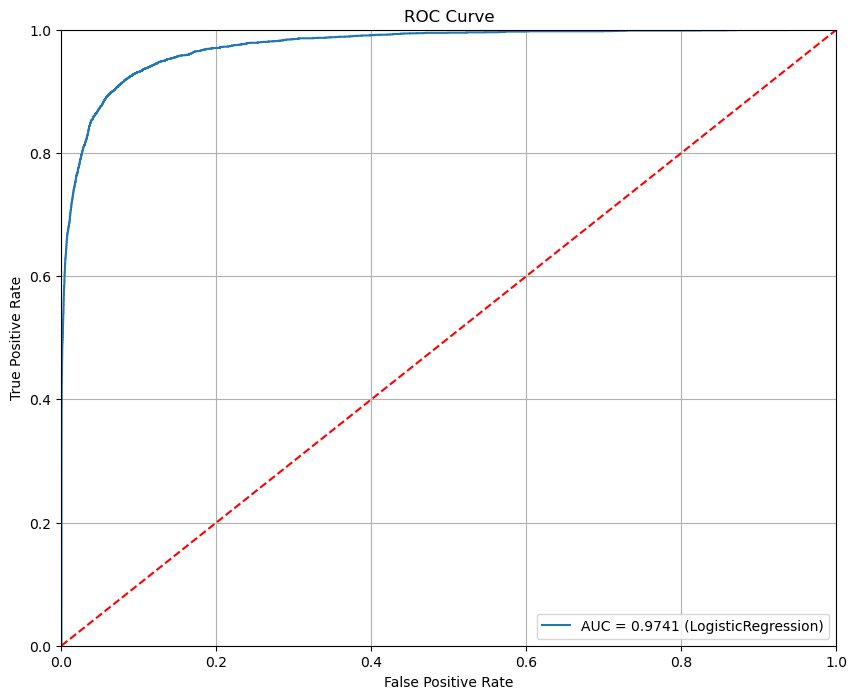

,LogisticRegression
fit time,16.472341
predict time,2.963765
score test,0.782291


In [22]:
scores_table = {}
for name, model in tqdm(model_.items()):
    scores_table[name] = hm.test_model(
        model, X_train, X_test, y_train, y_test, f1_score)

hm.roc_curve_plot(model_, X_test, y_test)
pd.DataFrame(scores_table)

## Выводы

Текстовые данные подготовлены очисткой от знаков пунктуации, приведением к нижнему регистру, лемматизацией слов

На всех рассмотренных моделях получено требуемое значение `f1`-метрики.

Лучше всего показывают себя модели, обученные на датасете с N-граммами (в нашем случае были рассмотрены пары слов)

Наибольшая площадь под ROC-кривой у модели логистической регрессии, обученной на данных векторизированных на униграммах и биграммах

Наивысшее значение метрики у классификатора LogisticRegression, обученного на данных векторизированных на униграммах и биграммах. Однако обучается такая модель в 2 раза дольше, чем на данных векторизированных только на униграммах